<a href="https://colab.research.google.com/github/givenone/deepintro/blob/master/forward_backward_kl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## KL divergence minimization

In this exercise, we will minimize KL divergence between the true distribution $p(x)$ and our model $q_\theta(x)$ using gradient descent. We will be utilizing [Tensorflow Probability (TFP)](https://www.tensorflow.org/probability) built on Tensorflow that makes it easy to combine probabilistic models and deep learning. If you haven't already, please go ahead and [install](https://www.tensorflow.org/probability/install) the library.


In [0]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
import subprocess

FIGSIZE = (6, 6)

In [0]:
# Evaluate the probabilities given the samples
def prob_map(p, lim, N):
    x = np.linspace(lim[0], lim[1], N)
    y = np.linspace(lim[2], lim[3], N)
    xy = np.array(np.meshgrid(x, y)).reshape(2, N**2).T
    xy_prob = p.prob(xy.astype(np.float32)).eval()
    x, y = np.meshgrid(x, y)
    return x, y, xy_prob.reshape((N, N))

# Create mean and covariance params for bivariate normal distribution
def gen_gaussian_params(d=2):
    p_mean = np.random.standard_normal((d,)).astype(np.float32)
    p_cov = np.random.standard_normal((d, d)).astype(np.float32)
    p_cov[0, 1] = 0
    p_cov = np.dot(p_cov, p_cov.T)
    return p_mean, p_cov

# Plot helpers
def contour(x, y, xy_prob, lim, cmap=plt.cm.inferno, axis=None):
    if axis is None:
        plt.contour(x, y, xy_prob, np.linspace(0., 1.1*xy_prob.max(), 10),
            zorder=2, extent=lim, linewidths=4, colors='w', alpha=0.5)
        plt.contour(x, y, xy_prob, np.linspace(0., 1.1*xy_prob.max(), 10),
                zorder=3, extent=lim, linewidths=2, cmap=cmap)
    else:
        axis.contour(x, y, xy_prob, np.linspace(0., 1.1*xy_prob.max(), 10),
            zorder=2, extent=lim, linewidths=4, colors='w', alpha=0.5)
        axis.contour(x, y, xy_prob, np.linspace(0., 1.1*xy_prob.max(), 10),
                zorder=3, extent=lim, linewidths=2, cmap=cmap)
    
def scatter(sample, axis=None):
    if axis is None:
        plt.scatter(sample[:200, 0], sample[:200, 1], s=25, alpha=0.7, c='k')
    else:
        axis.scatter(sample[:200, 0], sample[:200, 1], s=25, alpha=0.7, c='k')

### Create a bivariate normal as the true distribution $p(x) = \mathcal{N}(\mu, \Sigma)$

Draw the probability contour plot for the true distribution p(x)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


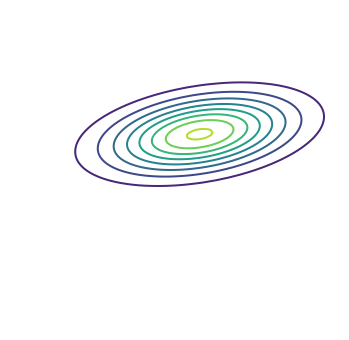

In [159]:
np.random.seed(555)
tf.reset_default_graph()
sess = tf.InteractiveSession()

p_mean, p_cov = gen_gaussian_params()
p_mean += 0.8
p = tfp.distributions.MultivariateNormalFullCovariance(p_mean, p_cov)

plt.figure(figsize=FIGSIZE)
N = 128
lim = [-2.5, 3.5, -2.5, 3.5]
x, y, xy_prob = prob_map(p, lim, N)
contour(x, y, xy_prob, lim, cmap=plt.cm.viridis)

plt.axis(lim)
plt.axis('off')
plt.show()

Draw samples from the true distribution $p(x)$ and visualize

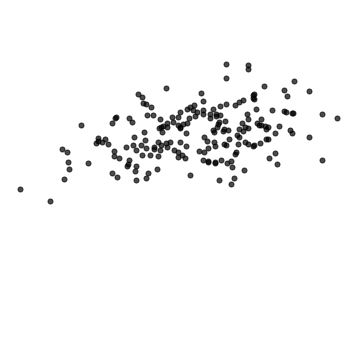

In [160]:
n_sample = 1000
sample = p.sample(n_sample).eval()

plt.figure(figsize=FIGSIZE)
scatter(sample)
plt.axis(lim)
plt.axis('off')
plt.show()

## Part A. Forward KL minimization

### Create the model distribution 
Now we will create $q_\theta(x)$ and apply gradient descent to minimize the forward KL divergence
$$\theta^* = \arg\min_\theta D_{KL}(p(x) \parallel q_\theta(x))$$

In [166]:
# Define your model here!
qm = np.random.standard_normal((2,)).astype(np.float32)
qr = np.random.standard_normal((2, 2)).astype(np.float32)

q_mean = tf.Variable(qm) # will convege to true p
q_raw  = tf.Variable(qr)
q_cov = tf.matmul(q_raw, tf.transpose(q_raw))

q = tfp.distributions.MultivariateNormalFullCovariance(q_mean, q_cov)
print(type(p_mean), type(q_mean))
# Define the loss here!
mu12 = tf.reshape(p_mean - q_mean, [1,2])
q_cov_inv = tf.linalg.inv(q_cov)
sum1 = tf.matmul(tf.matmul(mu12, q_cov_inv), tf.transpose(mu12))
trc = tf.linalg.trace(tf.matmul(q_cov_inv, p.covariance()))

loss = 0.5 * (tf.math.log(tf.linalg.det(q_cov)) + trc + sum1)
train = tf.train.GradientDescentOptimizer(0.1).minimize(loss, var_list = [q_mean, q_raw])
sess.run(tf.global_variables_initializer())

<class 'numpy.ndarray'> <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


Lets run it for 20 iterations and visualize $q_{\theta^{(t)}}(x)$ 

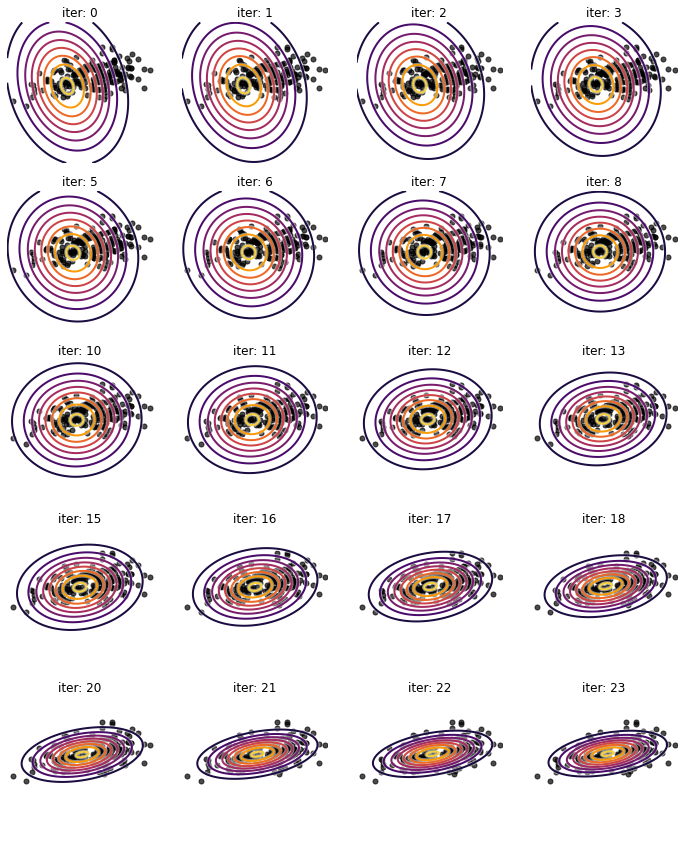

In [168]:
fig, axes = plt.subplots(5,4, figsize=[12, 15])

for i in range(5):
    for j in range(4):
        #print(q_raw.eval(session=sess), q_mean.eval(session=sess), q_temp.eval(session=sess))
        scatter(sample, axis=axes[i][j])
        x, y, xy_prob = prob_map(q, lim, N)
        contour(x, y, xy_prob, lim, axis=axes[i][j])
        axes[i][j].axis(lim)
        axes[i][j].axis('off')
        axes[i][j].set_title('iter: {}'.format(i*5 + j))
        sess.run(train)
        
plt.show()
plt.close(fig)

sess.close()

### Create a mixture of two bivariate normals as the true distribution
$p(x) = \pi_1 \mathcal{N}(\mu_1, \Sigma_1) + \pi_2 \mathcal{N}(\mu_2, \Sigma_2)$ where $\pi_1 + \pi_2 = 1$

In [170]:
def build_p(mix=0.8):
    return tfp.distributions.Mixture(
        cat=tfp.distributions.Categorical(probs=[mix, 1.-mix]),
        components=[
            tfp.distributions.MultivariateNormalFullCovariance(
                loc=[0.5, -0.7], covariance_matrix=[[1., 1.], [1., 2.]]),
            tfp.distributions.MultivariateNormalFullCovariance(
                loc=[-2.5, 2.5], covariance_matrix=[[0.5, 0.1], [0.1, 0.5]]),
        ])

np.random.seed(8)
tf.reset_default_graph()
sess = tf.InteractiveSession()

p = build_p()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Draw the probability contour plot for the true distribution p(x)

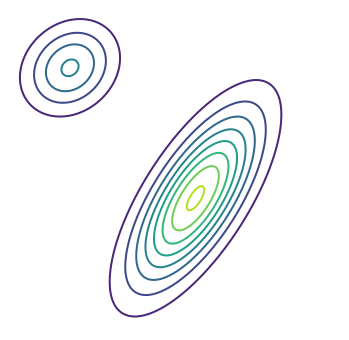

In [171]:
N = 128
lim = [-4, 4, -4, 4]
plt.figure(figsize=FIGSIZE)
x, y, xy_prob = prob_map(p, lim, N)
contour(x, y, xy_prob, lim, cmap=plt.cm.viridis)
plt.axis(lim)
plt.axis('off')
plt.show()

Draw samples from the true distribution $p(x)$ and visualize

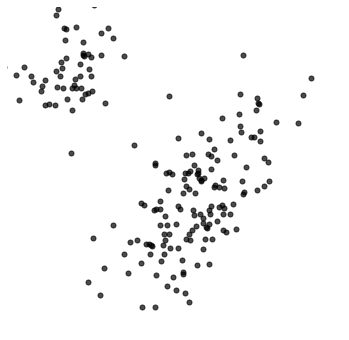

In [172]:
n_sample = 1000
sample = p.sample(n_sample).eval()
plt.figure(figsize=FIGSIZE)
scatter(sample)
plt.axis(lim)
plt.axis('off')
plt.show()

### Create the model distribution 
Now we will create $q_\theta(x)$ and apply gradient descent to minimize the forward KL divergence
$$\theta^* = \arg\min_\theta D_{KL}(p(x) \parallel q_\theta(x))$$

In [0]:
# Define your model here!
qm = np.random.standard_normal((2,)).astype(np.float32)
qr = np.random.standard_normal((2, 2)).astype(np.float32)

q_mean = tf.Variable(qm) # will convege to true p
q_raw  = tf.Variable(qr)
q_cov = tf.matmul(q_raw, tf.transpose(q_raw))
#print(a.dtype,b,q_mean)
q = tfp.distributions.MultivariateNormalFullCovariance(q_mean, q_cov)

p_mean = np.mean(sample, axis = 0)
p_cov = np.matmul((sample - p_mean).T, sample - p_mean) / n_sample

#print(sample.shape, p_mean.shape, p_cov.shape)

# Define the loss here!
mu12 = tf.reshape(p_mean - q_mean, [1,2])
q_cov_inv = tf.linalg.inv(q_cov)
sum1 = tf.matmul(tf.matmul(mu12, q_cov_inv), tf.transpose(mu12))
trc = tf.linalg.trace(tf.matmul(q_cov_inv, p_cov))

loss = 0.5 * (tf.math.log(tf.linalg.det(q_cov)) + trc + sum1)

# Define the loss here!
#logp = None
train = tf.train.GradientDescentOptimizer(0.1).minimize(loss, var_list = [q_mean, q_raw])
sess.run(tf.global_variables_initializer())

Lets run it for 20 iterations and visualize $q_{\theta^{(t)}}(x)$ 

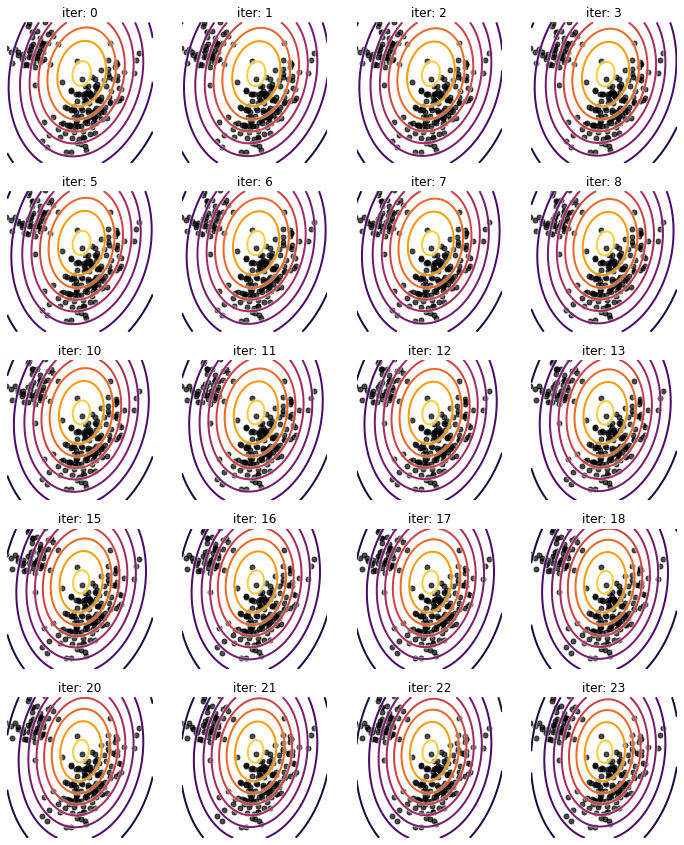

In [174]:
fig, axes = plt.subplots(5,4, figsize=[12, 15])

for i in range(5):
    for j in range(4):
        scatter(sample, axis=axes[i][j])
        x, y, xy_prob = prob_map(q, lim, N)
        contour(x, y, xy_prob, lim, axis=axes[i][j])
        axes[i][j].axis(lim)
        axes[i][j].axis('off')
        axes[i][j].set_title('iter: {}'.format(i*5 + j))
        sess.run(train)
        
plt.show()
plt.close(fig)

sess.close()

## Part B. Reverse KL minimization

In [203]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
p = build_p()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Create the model distribution 
Now we will create $q_\theta(x)$ and apply gradient descent to minimize the reverse KL divergence
$$\theta^* = \arg\min_\theta D_{KL}(q_\theta(x) \parallel p(x))$$

In [0]:
# Define your model here!
qm = np.random.standard_normal((2,)).astype(np.float32)
qr = np.random.standard_normal((2, 2)).astype(np.float32)

q_mean = tf.Variable(qm) # will convege to true p
q_raw  = tf.Variable(qr)
q_cov = tf.matmul(q_raw, tf.transpose(q_raw))

## 2 -> p, 1 -> q

q = tfp.distributions.MultivariateNormalFullCovariance(q_mean, q_cov)

p_cov_inv = tf.linalg.inv(p_cov)
trc = tf.linalg.trace(tf.matmul(p_cov_inv, q_cov))
lg = tf.math.log((tf.linalg.det(p_cov) / tf.linalg.det(q_cov)))

mu12 = tf.reshape(p_mean - q_mean, [1,2])
sum1 = tf.matmul(tf.matmul(mu12, p_cov_inv), tf.transpose(mu12))
# Define the loss here!
loss = 0.5 * (lg - 2 + trc + sum1)
train = tf.train.GradientDescentOptimizer(0.1).minimize(loss, var_list = [q_mean, q_raw])
sess.run(tf.global_variables_initializer())



Lets run it for 20 iterations and visualize $q_{\theta^{(t)}}(x)$ 

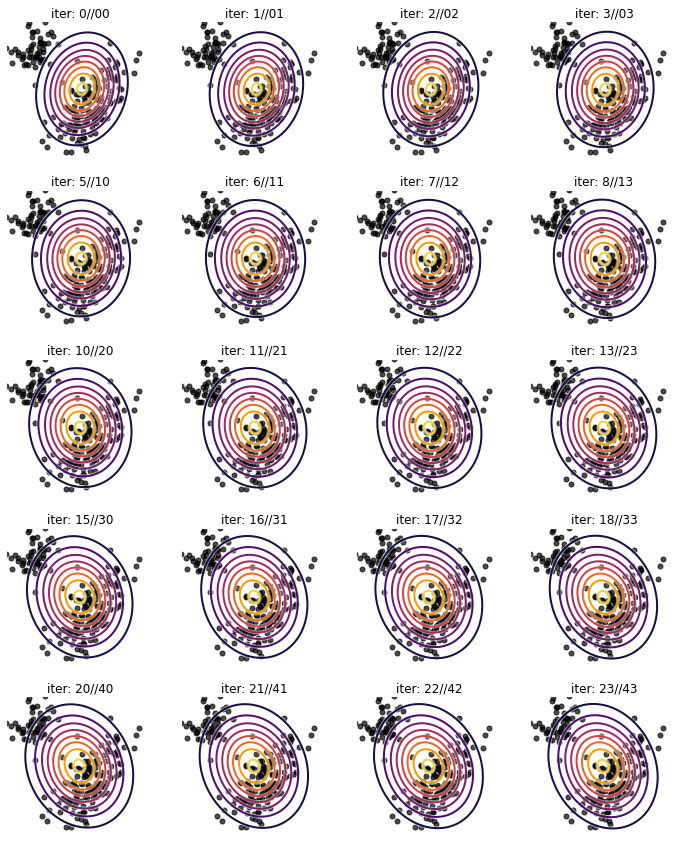

In [207]:
fig, axes = plt.subplots(5,4, figsize=[12, 15])

for i in range(5):
    for j in range(4):
        scatter(sample, axis=axes[i][j])
        x, y, xy_prob = prob_map(q, lim, N)
        contour(x, y, xy_prob, lim, axis=axes[i][j])
        axes[i][j].axis(lim)
        axes[i][j].axis('off')
        axes[i][j].set_title('iter: {}'.format(i*5 + j))
        sess.run(train)
        
plt.show()
plt.close(fig)

sess.close()